In [1]:
import numpy as np
import pandas as pd

#Import packages for visualization of results
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Import packages for evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

# KNN Classifier

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

In [3]:
#Load the dataset
churnScaled = pd.read_csv("data/processed/smote_scaled_balanced.csv")

#Replace boolean values with numeric ones for euclidian distance
churnScaled.replace({True:1,False:0}, inplace=True)

#Separate features and target
kNN_X = churnScaled.drop("Churn", axis=1)
kNN_y = churnScaled["Churn"]

C:\Users\korie\AppData\Local\Temp\ipykernel_44312\3134090289.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churnScaled.replace({True:1,False:0}, inplace=True)


In [4]:
#Force X to be an array to avoid 'Flags' object has no attribute 'c_contiguous' error in cross validation
kNN_X_array = np.array(kNN_X)

In [5]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(kNN_X_array, np.ravel(kNN_y), test_size = 0.3, random_state=42)

## GridSearchCV to find optimal k

In [6]:
#Initialize classifier
knnModel = KNeighborsClassifier()

#Create tuning grid
k = {'n_neighbors': [3,5,7,9,11,13]}

#Initialize tuning grid and fit to training data
knnTuning = GridSearchCV(knnModel, k)
knnTuning.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [3, 5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


In [7]:
#Print the best k value and corresponding score
print(f"The best estimated value of K is: ", knnTuning.best_estimator_)

The best estimated value of K is:  KNeighborsClassifier(n_neighbors=3)


## Train model and make predictions

In [8]:
#Initialize classifier with k = 3 and train model
knn = knnTuning.best_estimator_
knn.fit(X_train, y_train)

#Make predictions
y_pred = knn.predict(X_test)

## Compute metrics

In [9]:
print(f"Accuracy score: ", metrics.accuracy_score(y_test, y_pred))
print(f"Recall score: ", metrics.recall_score(y_test, y_pred))
print(f"Confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))
#recall more important for churn rate - want less false negatives 
#(would rather assume a customer is at risk of leaving rather than miss an opportunity when someone is at risk of leaving)
print(f"Classification report: ")
print(metrics.classification_report(y_test, y_pred))

Accuracy score:  0.802130406714009
Recall score:  0.8938110749185668
Confusion matrix: 
[[1113  450]
 [ 163 1372]]
Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1563
           1       0.75      0.89      0.82      1535

    accuracy                           0.80      3098
   macro avg       0.81      0.80      0.80      3098
weighted avg       0.81      0.80      0.80      3098



## Determining Feature Importance with permutation

In [10]:
from sklearn.inspection import permutation_importance
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Show importance - based on what?
feature_names = churnScaled.drop("Churn", axis=1).columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                  feature  importance
1                                  tenure    0.076566
3                            TotalCharges    0.046482
2                          MonthlyCharges    0.026953
4                             gender_Male    0.016269
28         PaymentMethod_Electronic check    0.014235
15                       OnlineBackup_Yes    0.012718
5                             Partner_Yes    0.011943
24                      Contract_One year    0.011814
13                     OnlineSecurity_Yes    0.011653
0                           SeniorCitizen    0.010523
10            InternetService_Fiber optic    0.010458
26                   PaperlessBilling_Yes    0.010458
9                       MultipleLines_Yes    0.009684
19                        TechSupport_Yes    0.009684
23                    StreamingMovies_Yes    0.008522
17                   DeviceProtection_Yes    0.008263
6                          Dependents_Yes    0.007908
21                        St

## Plotting - Decision Boundary

PCA TO 2D

In [11]:
#Sample for plotting to reduce computational expense
churnSample = churnScaled.sample(200, random_state=123)

#Separate features and target
X_Sample = churnSample.drop("Churn", axis=1)
y_Sample = churnSample["Churn"]

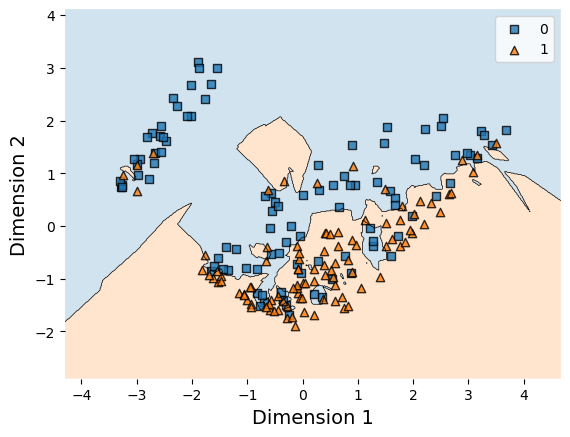

In [12]:
from sklearn.decomposition import PCA

#Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_Sample)

#Initialize classifier and fit with 2D data
knnPCA = knnTuning.best_estimator_
knnPCA.fit(X_pca, np.ravel(y_Sample))
           
#Set background opacity to 20%
contourf_kwargs = {'alpha': 0.2}

# Plot decision regions
p = plot_decision_regions(X_pca, np.ravel(y_Sample), clf=knnPCA, contourf_kwargs=contourf_kwargs)

p.set_xlabel("Dimension 1", fontsize=14)
p.set_ylabel("Dimension 2", fontsize=14)

L = plt.legend()

Not interpretable

2D TOP IMPORTANT FEATURES

C:\Users\korie\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


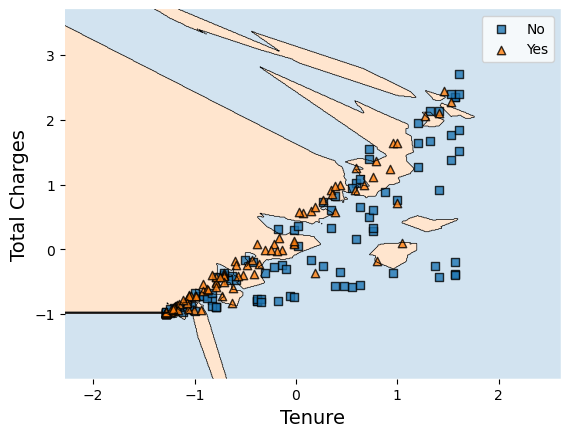

In [13]:
# Plot decision regions

#Define input features
X_2_Features = churnSample[['tenure','TotalCharges']]

#Initialize and fit model
knnSample = knnTuning.best_estimator_
knnSample.fit(X_2_Features, np.ravel(y_Sample))

#plot decision boundary regions
p2 = plot_decision_regions(X_2_Features.to_numpy(), np.ravel(y_Sample), clf=knnSample, contourf_kwargs=contourf_kwargs)

#add title and axis labels
p2.set_xlabel("Tenure", fontsize=14)
p2.set_ylabel("Total Charges", fontsize=14)

#create a legend
L = plt.legend()

L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')

# Random Forest - SMOTE

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [15]:
#Load dataset
churnSMOTE = pd.read_csv("data/processed/smote_unscaled_balanced.csv")

In [16]:
#Replace boolean values with numeric ones for binary classification
churnSMOTE.replace({True:1,False:0}, inplace=True)

#Select input and output features
rf_X = churnSMOTE.drop("Churn", axis=1)
rf_y = churnSMOTE["Churn"]

C:\Users\korie\AppData\Local\Temp\ipykernel_44312\3022174917.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churnSMOTE.replace({True:1,False:0}, inplace=True)


In [17]:
#Split data into training and testing sets
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, np.ravel(rf_y), test_size = 0.3, random_state=42)

## Train model and make predictions

In [18]:
#Initialize and fit model
rfModel = RandomForestClassifier()
rfModel.fit(rf_X_train, np.ravel(rf_y_train))

#predict
rf_y_pred = rfModel.predict(rf_X_test)

## Compute Metrics

In [19]:
print(f"Accuracy score: ", metrics.accuracy_score(rf_y_test, rf_y_pred))
print(f"Recall score: ", metrics.recall_score(rf_y_test, rf_y_pred))
print(f"Confusion matrix: ")
print(metrics.confusion_matrix(rf_y_test, rf_y_pred))
#recall more important for churn rate - want less false negatives 
#(would rather assume a customer is at risk of leaving rather than miss an opportunity when someone is at risk of leaving)
print(f"Classification report: ")
print(metrics.classification_report(rf_y_test, rf_y_pred))

Accuracy score:  0.8486120077469335
Recall score:  0.8495114006514658
Confusion matrix: 
[[1325  238]
 [ 231 1304]]
Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1563
           1       0.85      0.85      0.85      1535

    accuracy                           0.85      3098
   macro avg       0.85      0.85      0.85      3098
weighted avg       0.85      0.85      0.85      3098



## Determine Feature Importance

In [20]:
#Variable importance table
df_importance = pd.DataFrame(
    data={
        "feature": rfModel.feature_names_in_,
        "importance": rfModel.feature_importances_,
    }
).sort_values("importance", ascending=False)
print(df_importance)

                                  feature  importance
1                                  tenure    0.169962
3                            TotalCharges    0.164823
2                          MonthlyCharges    0.135464
28         PaymentMethod_Electronic check    0.091161
10            InternetService_Fiber optic    0.054721
26                   PaperlessBilling_Yes    0.042664
25                      Contract_Two year    0.036191
4                             gender_Male    0.024024
9                       MultipleLines_Yes    0.023836
24                      Contract_One year    0.020911
21                        StreamingTV_Yes    0.017673
23                    StreamingMovies_Yes    0.017590
15                       OnlineBackup_Yes    0.017514
13                     OnlineSecurity_Yes    0.017446
5                             Partner_Yes    0.017289
27  PaymentMethod_Credit card (automatic)    0.016880
19                        TechSupport_Yes    0.016657
17                   DeviceP

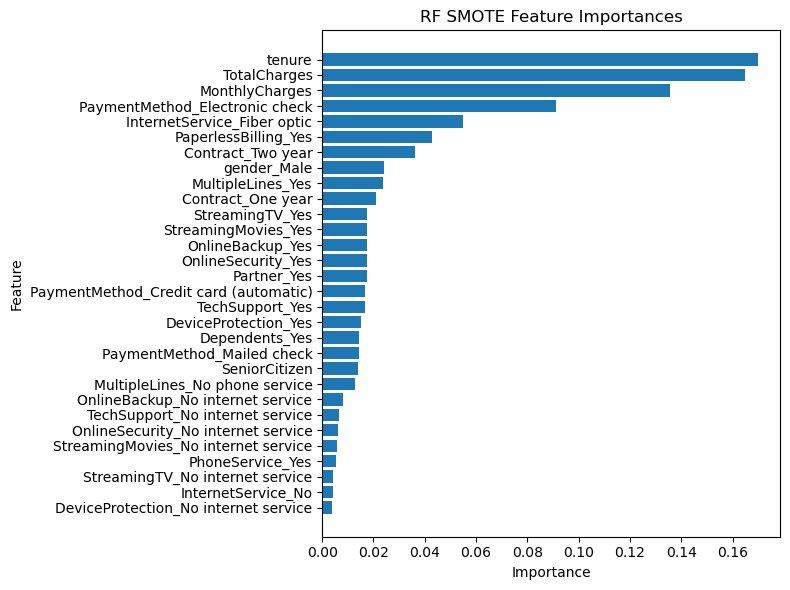

In [21]:
#plot bar graph
plt.figure(figsize=(8, 6))
plt.barh(df_importance["feature"], df_importance["importance"])
plt.gca().invert_yaxis()  # Highest importance at the top

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("RF SMOTE Feature Importances")
plt.tight_layout()
plt.show()

## Visualize Most Important Tree

In [22]:
# Extract feature importances for each tree
tree_importances = [est.feature_importances_.sum() for est in rfModel.estimators_]

# Index of the most important tree
most_important_tree_idx = np.argmax(tree_importances)
best_tree = rfModel.estimators_[most_important_tree_idx]

print("Most important tree index:", most_important_tree_idx)

Most important tree index: 6


In [23]:
from sklearn import tree

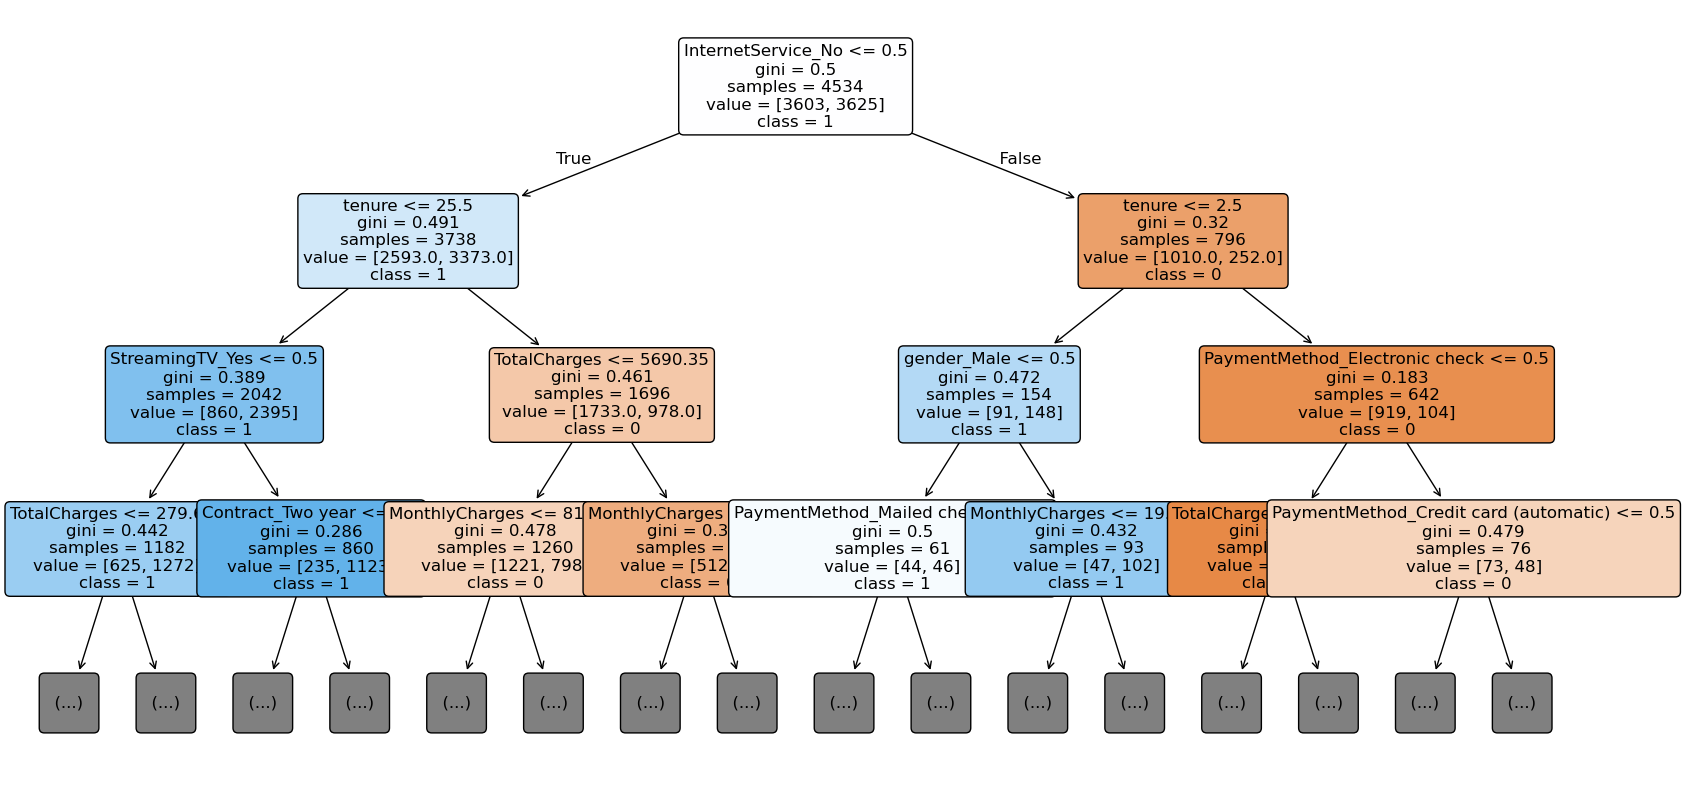

In [24]:
plt.figure(figsize=(20, 10))
tree.plot_tree(
    best_tree,
    feature_names=rf_X_train.columns,
    class_names=[str(c) for c in rfModel.classes_],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12
)
plt.show()

## ROC Curve

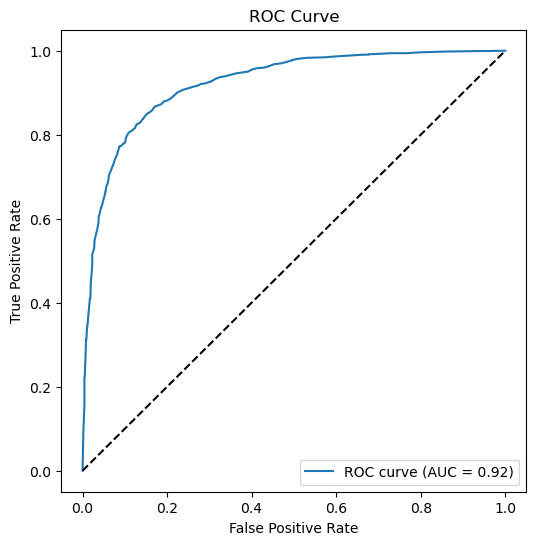

In [25]:
from sklearn.metrics import roc_curve, auc

y_prob = rfModel.predict_proba(rf_X_test)[:, 1]
fpr, tpr, _ = roc_curve(rf_y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Train Model with Top Features

In [26]:
#Select input and output features
rf_7_X = churnSMOTE[['tenure','TotalCharges','MonthlyCharges','PaymentMethod_Electronic check','InternetService_Fiber optic','PaperlessBilling_Yes', 'Contract_Two year']]
rf_7_y = churnSMOTE["Churn"]

#Split data into training and testing sets
rf_7_X_train, rf_7_X_test, rf_7_y_train, rf_7_y_test = train_test_split(rf_7_X, np.ravel(rf_7_y), test_size = 0.3, random_state=42)

#Initialize and fit model
rf7Model = RandomForestClassifier()
rf7Model.fit(rf_7_X_train, np.ravel(rf_7_y_train))

#predict
rf_7_y_pred = rf7Model.predict(rf_7_X_test)

In [27]:
print(f"Accuracy score: ", metrics.accuracy_score(rf_7_y_test, rf_7_y_pred))
print(f"Recall score: ", metrics.recall_score(rf_7_y_test, rf_7_y_pred))
print(f"Confusion matrix: ")
print(metrics.confusion_matrix(rf_7_y_test, rf_7_y_pred))
#recall more important for churn rate - want less false negatives 
#(would rather assume a customer is at risk of leaving rather than miss an opportunity when someone is at risk of leaving)
print(f"Classification report: ")
print(metrics.classification_report(rf_7_y_test, rf_7_y_pred))

Accuracy score:  0.8063266623628147
Recall score:  0.8130293159609121
Confusion matrix: 
[[1250  313]
 [ 287 1248]]
Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1563
           1       0.80      0.81      0.81      1535

    accuracy                           0.81      3098
   macro avg       0.81      0.81      0.81      3098
weighted avg       0.81      0.81      0.81      3098



With less data, loses accuracy

# Random Forest - Class Weights

In [28]:
#Load dataset
churnUnscaled = pd.read_csv("data/processed/preprocessed_unscaled.csv")

In [29]:
#Replace boolean values with numeric ones for binary classification
churnUnscaled.replace({True:1,False:0}, inplace=True)

#Select input and output features
rf_imb_X = churnUnscaled.drop("Churn", axis=1)
rf_imb_y = churnUnscaled["Churn"]

C:\Users\korie\AppData\Local\Temp\ipykernel_44312\1375677691.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churnUnscaled.replace({True:1,False:0}, inplace=True)


In [30]:
#Split data into training and testing sets
rfImb_X_train, rfImb_X_test, rfImb_y_train, rfImb_y_test = train_test_split(rf_imb_X, np.ravel(rf_imb_y), test_size = 0.3, random_state=42)

## Determine the best weights - GridSearchCV

In [31]:
weights = [
    {0:1, 1:1},
    {0:1, 1:2},
    {0:1, 1:3},
    {0:1, 1:5},
    "balanced"
]

In [32]:
param_grid = {
    "class_weight": weights,
    "n_estimators": [100,200],
    "max_depth": [10,20,None]
}

In [33]:
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy"
)

grid.fit(rfImb_X_train, rfImb_y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, ...], 'max_depth': [10, 20, ...], 'n_estimators': [100, 200]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [34]:
print(f"Best parameters found: {grid.best_params_}")
print(f"Best accuracy score: {grid.best_score_}")

best_model = grid.best_estimator_

Best parameters found: {'class_weight': {0: 1, 1: 1}, 'max_depth': 10, 'n_estimators': 100}
Best accuracy score: 0.8015071602492675


# Random Forest - Best Estimator

## Train model and make predictions

In [35]:
#Initialize and fit model
rf_WeighModel = grid.best_estimator_
rf_WeighModel.fit(rfImb_X_train, np.ravel(rfImb_y_train))

#predict
rfWeigh_y_pred = rf_WeighModel.predict(rfImb_X_test)

## Compute Metrics

In [36]:
print(f"Accuracy score: ", metrics.accuracy_score(rfImb_y_test, rfWeigh_y_pred))
print(f"Recall score: ", metrics.recall_score(rfImb_y_test, rfWeigh_y_pred))
print(f"Confusion matrix: ")
print(metrics.confusion_matrix(rfImb_y_test, rfWeigh_y_pred))
#recall more important for churn rate - want less false negatives 
#(would rather assume a customer is at risk of leaving rather than miss an opportunity when someone is at risk of leaving)
print(f"Classification report: ")
print(metrics.classification_report(rfImb_y_test, rfWeigh_y_pred))

Accuracy score:  0.7976303317535545
Recall score:  0.49019607843137253
Confusion matrix: 
[[1408  141]
 [ 286  275]]
Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.66      0.49      0.56       561

    accuracy                           0.80      2110
   macro avg       0.75      0.70      0.72      2110
weighted avg       0.79      0.80      0.79      2110



## Determine Feature Importance

In [37]:
#Variable importance table
pd.DataFrame(
    data={
        "feature": rf_WeighModel.feature_names_in_,
        "importance": rf_WeighModel.feature_importances_,
    }
).sort_values("importance", ascending=False)

,feature,importance
1,tenure,0.189303
3,TotalCharges,0.162454
2,MonthlyCharges,0.134201
10,InternetService_Fiber optic,0.071185
25,Contract_Two year,0.049533
28,PaymentMethod_Electronic check,0.047421
24,Contract_One year,0.035894
13,OnlineSecurity_Yes,0.033541
19,TechSupport_Yes,0.026208
26,PaperlessBilling_Yes,0.020145


## ROC Curve

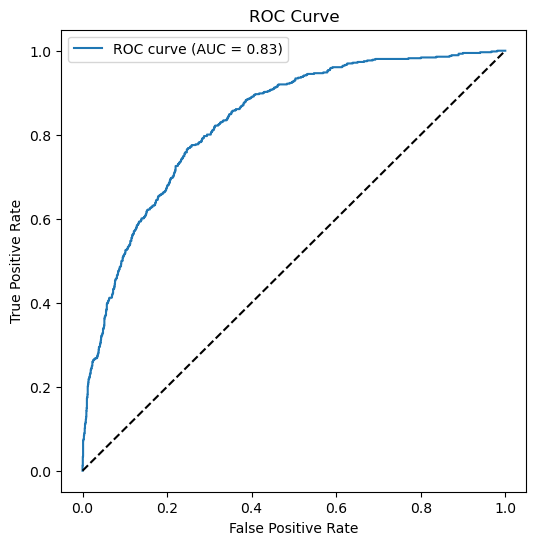

In [38]:
y_prob_est = rf_WeighModel.predict_proba(rfImb_X_test)[:, 1]
fpr, tpr, _ = roc_curve(rfImb_y_test, y_prob_est)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Random Forest - 'Balanced'

## Train model and make predictions

In [39]:
#Initialize and fit model
rf_ImbModel = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_ImbModel.fit(rfImb_X_train, np.ravel(rfImb_y_train))

#predict
rfImb_y_pred = rf_ImbModel.predict(rfImb_X_test)

## Compute Metrics

In [40]:
print(f"Accuracy score: ", metrics.accuracy_score(rfImb_y_test, rfImb_y_pred))
print(f"Recall score: ", metrics.recall_score(rfImb_y_test, rfImb_y_pred))
print(f"Confusion matrix: ")
print(metrics.confusion_matrix(rfImb_y_test, rfImb_y_pred))
#recall more important for churn rate - want less false negatives 
#(would rather assume a customer is at risk of leaving rather than miss an opportunity when someone is at risk of leaving)
print(f"Classification report: ")
print(metrics.classification_report(rfImb_y_test, rfImb_y_pred))

Accuracy score:  0.7853080568720379
Recall score:  0.46702317290552586
Confusion matrix: 
[[1395  154]
 [ 299  262]]
Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1549
           1       0.63      0.47      0.54       561

    accuracy                           0.79      2110
   macro avg       0.73      0.68      0.70      2110
weighted avg       0.77      0.79      0.77      2110



## Determine Feature Importance

In [41]:
#Variable importance table
pd.DataFrame(
    data={
        "feature": rf_ImbModel.feature_names_in_,
        "importance": rf_ImbModel.feature_importances_,
    }
).sort_values("importance", ascending=False)

,feature,importance
1,tenure,0.172762
3,TotalCharges,0.168929
2,MonthlyCharges,0.156982
25,Contract_Two year,0.056856
10,InternetService_Fiber optic,0.040950
28,PaymentMethod_Electronic check,0.033203
24,Contract_One year,0.032165
13,OnlineSecurity_Yes,0.029276
4,gender_Male,0.025364
19,TechSupport_Yes,0.023957


## ROC Curve

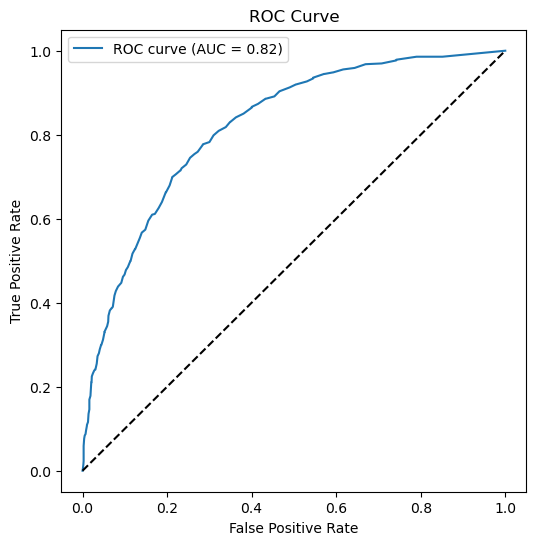

In [42]:
y_prob_bal = rf_ImbModel.predict_proba(rfImb_X_test)[:, 1]
fpr, tpr, _ = roc_curve(rfImb_y_test, y_prob_bal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## All ROCs

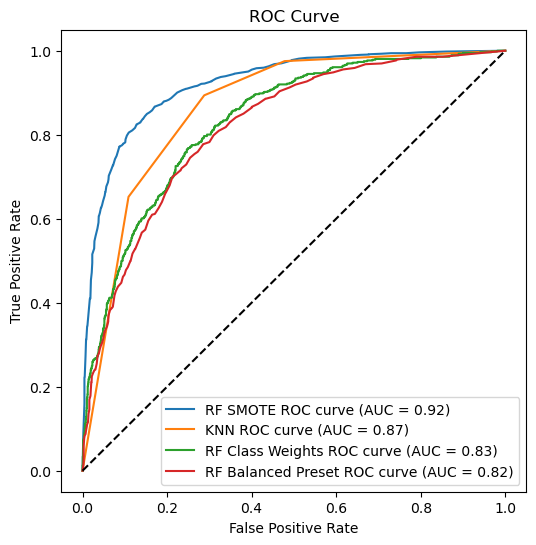

In [43]:
#ROCs all on one graph

#knn
knn_ROC = knnTuning.best_estimator_
knn_ROC.fit(X_train, y_train)
y_prob_knn = knn_ROC.predict_proba(X_test)[:, 1] 
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

#SMOTE
fpr_SMOTE, tpr_SMOTE, _ = roc_curve(rf_y_test, y_prob)
roc_auc_SMOTE = auc(fpr_SMOTE, tpr_SMOTE)

#Best Estimator
fpr_est, tpr_est, _ = roc_curve(rfImb_y_test, y_prob_est)
roc_auc_est = auc(fpr_est, tpr_est)

#'Balanced'
fpr_bal, tpr_bal, _ = roc_curve(rfImb_y_test, y_prob_bal)
roc_auc_bal = auc(fpr_bal, tpr_bal)

plt.figure(figsize=(6,6))
plt.plot(fpr_SMOTE, tpr_SMOTE, label=f'RF SMOTE ROC curve (AUC = {roc_auc_SMOTE:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN ROC curve (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_est, tpr_est, label=f'RF Class Weights ROC curve (AUC = {roc_auc_est:.2f})')
plt.plot(fpr_bal, tpr_bal, label=f'RF Balanced Preset ROC curve (AUC = {roc_auc_bal:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Cross Validation

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [45]:
#Define a set of cross-validation folds
kf = KFold(n_splits=10, random_state=19,  shuffle=True)

## Compute cross validation results

In [46]:
#knn
knnResults = cross_validate(knn, X_train, np.ravel(y_train), cv = kf)
knnScores = knnResults['test_score']

#Random Forest SMOTE
rfSMOTE = cross_validate(rfModel, rf_X_train, np.ravel(rf_y_train), cv = kf)
rfSMOTEScores = rfSMOTE['test_score']

#Random Forest Best Estimator
rfBestEst = cross_validate(rf_WeighModel, rfImb_X_train, np.ravel(rfImb_y_train), cv = kf)
rfBestEstScores = rfBestEst['test_score']

#Random Forest 'balanced'
rfWeighBal = cross_validate(rf_ImbModel, rfImb_X_train, np.ravel(rfImb_y_train), cv = kf)
rfWeighBalScores = rfWeighBal['test_score']

## Plot the data

In [47]:
#Combine scores from all models into a dataframe
df = pd.DataFrame({'knn': knnScores, 'rf SMOTE': rfSMOTEScores, 'rf Class Weights': rfBestEstScores, 'rf Balanced': rfWeighBalScores})

C:\Users\korie\AppData\Local\Temp\ipykernel_44312\3253579959.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Score', data=df_melted, palette="Set2")


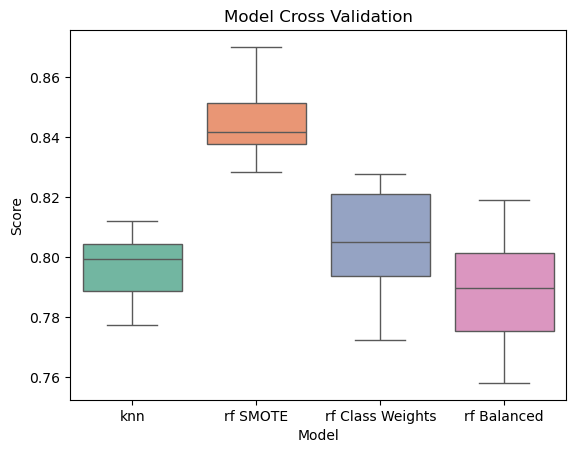

In [48]:
df_melted = df.melt(var_name='Model', value_name='Score')

#Create the boxplot
sns.boxplot(x='Model', y='Score', data=df_melted, palette="Set2")
plt.title("Model Cross Validation")
plt.show()